# Phosphoproteomics scoring

## Setup

In [ ]:
# !pip install git+https://github.com/sky1ove/katlas.git -Uq

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from katlas.core import *
from katlas.plot import *
import seaborn as sns
from tqdm import tqdm
import numpy as np

tqdm.pandas()

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Combine phosphoplus and ochoa

There are three datasets of phosphorylation sites:
- CPTAC pan cancer
- ochoa et al. paper
- phosphoplus

In [ ]:
ochoa = Data.get_ochoa_site()
# cptac = Data.get_cptac_ensembl_site()
pplus = Data.get_psp_human_site()

In [ ]:
pplus['site_seq'] = pplus.site_seq.str.upper()

pplus['gene'] =pplus['gene'].fillna(pplus.uniprot)

pplus['gene_site'] = pplus.gene+"_"+pplus.site

pplus = pplus[pplus.LT_LIT.notna()]

pplus = pplus[['gene','gene_site','site_seq']]

In [ ]:
ochoa['gene'] = ochoa.gene_site.str.split('_').str[0]

ochoa = ochoa[['gene','gene_site','site_seq']]

In [ ]:
pplus['source'] = 'phosphoplus'

ochoa['source']='ochoa'

In [ ]:
pplus.shape

(15113, 4)

In [ ]:
ochoa.shape

(112281, 4)

In [ ]:
comb = pd.concat([pplus,ochoa]).reset_index(drop=True)

In [ ]:
idx = comb.iloc[:,:3].drop_duplicates().index

In [ ]:
comb = comb.loc[idx]

In [ ]:
comb.source.value_counts()

ochoa          108885
phosphoplus     15026
Name: source, dtype: int64

In [ ]:
comb=comb[comb.site_seq.str[7].isin(['S','T','Y'])]

In [ ]:
comb.shape

(123890, 4)

In [ ]:
comb.source.value_counts()

ochoa          108885
phosphoplus     15005
Name: source, dtype: int64

In [ ]:
# def plot_count(cnt,tick_spacing = None,palette='tab20'):

#     c = sns.color_palette(palette)
#     ax = cnt.plot.barh(color = c)

#     for index, value in enumerate(cnt):
#         plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')
#         # Set x-ticks at regular intervals
#     if tick_spacing is not None:
#         ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))


### Get unique site

In [ ]:
def get_unique(x): return '|'.join(x.unique())

In [ ]:
unique = comb.groupby('site_seq').agg(
    {'gene_site': get_unique, 
     'gene': get_unique,
    'source': get_unique} )

unique['num_site'] = unique['gene_site'].str.split('|').apply(len)

unique = unique.reset_index()

unique['acceptor'] = unique['site_seq'].str[7]

In [ ]:
unique

,site_seq,gene_site,gene,source,num_site,acceptor
0,AAAAAAASGGAGSDN,PBX1_S136,PBX1,ochoa,1,S
1,AAAAAAASGGGVSPD,PBX2_S146,PBX2,ochoa,1,S
2,AAAAAAASGVTTGKP,CLASR_S349,CLASR,ochoa,1,S
3,AAAAAAASQQGSAKN,TBL1R_S119,TBL1R,ochoa,1,S
4,AAAAAAASSPVGVGQ,SOX3_S249,SOX3,ochoa,1,S
...,...,...,...,...,...,...
116882,______MYHSLSETR,TBCD5_Y2,TBCD5,ochoa,1,Y
116883,______MYPESTTGS,KCAB2_Y2,KCAB2,ochoa,1,Y
116884,______MYTAIPQSG,CAPG_Y2,CAPG,ochoa,1,Y
116885,_______SGRGKGGK,H4C1_S1,H4C1,phosphoplus,1,S


In [ ]:
split = unique.site_seq.apply(list).apply(pd.Series)

split.columns = [i for i in range(-7,8)]

unique = pd.concat([unique,split],axis=1)

In [ ]:
unique.columns = unique.columns.astype(str)
# unique.to_parquet('combine_site_ochoa_pplus.parquet')

In [ ]:
# to load
# unique = Data.get_combine_site_pplus_ochoa()

In [ ]:
unique.shape

(116887, 21)

### EDA and functions

In [ ]:
def query_gene(df,gene):
    
    "Query gene in the phosphoproteomics dataset"
    
    # query gene in the dataframe
    df_gene = df[df.gene_site.str.contains(f'{gene}_')]
    
    # sort dataframe based on position
    sort_position = df_gene.gene_site.str.split('_').str[-1].str[1:].astype(int).sort_values().index
    df_gene = df_gene.loc[sort_position]
    
    return df_gene

In [ ]:
query_gene(unique,'TP53')[:10]

,site_seq,gene_site,gene,source,num_site,acceptor,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7
115584,__MEEPQSDPSVEPP,TP53_S6|P53_S6,TP53|P53,phosphoplus|ochoa,2,S,_,_,M,E,E,P,Q,S,D,P,S,V,E,P,P
115282,_MDDLMLSPDDIEQW,TP53_S7,TP53,phosphoplus,1,S,_,M,D,D,L,M,L,S,P,D,D,I,E,Q,W
17936,EEPQSDPSVEPPLSQ,TP53_S9|P53_S9,TP53|P53,phosphoplus|ochoa,2,S,E,E,P,Q,S,D,P,S,V,E,P,P,L,S,Q
71937,PSVEPPLSQETFSDL,TP53_S15|P53_S15,TP53|P53,phosphoplus|ochoa,2,S,P,S,V,E,P,P,L,S,Q,E,T,F,S,D,L
21635,EPPLSQETFSDLWKL,TP53_T18,TP53,phosphoplus,1,T,E,P,P,L,S,Q,E,T,F,S,D,L,W,K,L
67813,PLSQETFSDLWKLLP,TP53_S20,TP53,phosphoplus,1,S,P,L,S,Q,E,T,F,S,D,L,W,K,L,L,P
53375,LPENNVLSPLPSQAM,TP53_S33,TP53,phosphoplus,1,S,L,P,E,N,N,V,L,S,P,L,P,S,Q,A,M
62644,NVLSPLPSQAMDDLM,TP53_S37,TP53,phosphoplus,1,S,N,V,L,S,P,L,P,S,Q,A,M,D,D,L,M
4244,AMDDLMLSPDDIEQW,TP53_S46,TP53,phosphoplus,1,S,A,M,D,D,L,M,L,S,P,D,D,I,E,Q,W
10328,DDIEQWFTEDPGPDE,TP53_T55,TP53,phosphoplus,1,T,D,D,I,E,Q,W,F,T,E,D,P,G,P,D,E


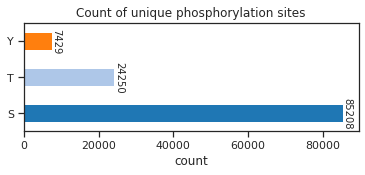

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

plt.figure(figsize=(6,2))
plot_count(unique.acceptor.value_counts(),20000)
plt.title('Count of unique phosphorylation sites')
plt.xlabel('count');

In [ ]:
list(range(-7,8))

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

In [ ]:
unique.columns = unique.columns[:-15].tolist() + [i for i in range(-7,8)]

In [ ]:
unique.columns

Index([ 'site_seq', 'gene_site',      'gene',    'source',  'num_site',
        'acceptor',          -7,          -6,          -5,          -4,
                -3,          -2,          -1,           0,           1,
                 2,           3,           4,           5,           6,
                 7],
      dtype='object')

In [ ]:
paper,full=get_freq(unique)

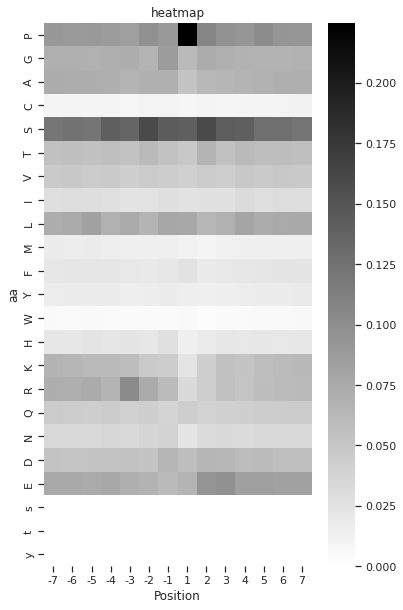

In [ ]:
plot_heatmap(full.drop(columns=[0]))

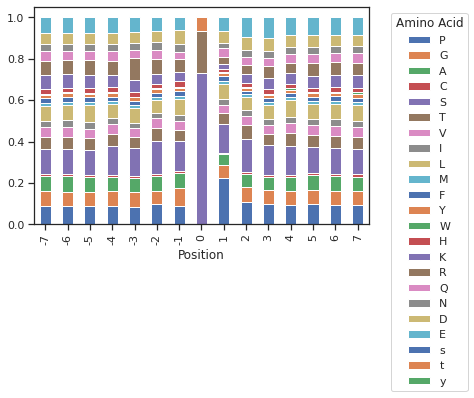

In [ ]:
full.T.plot.bar(stacked=True)
plt.legend(title='Amino Acid', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Position');

## Substrate scoring

In [ ]:
results = predict_kinase_df(unique,'site_seq',**param_CDDM_upper)

input dataframe has a length 116887
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [02:26<00:00,  1.97it/s]


In [ ]:
results_pspa = predict_kinase_df(unique,'site_seq',**param_PSPA_st)

input dataframe has a length 116887
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


  0%|          | 0/303 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/katlas/core.py:470: RuntimeWarning: divide by zero encountered in log2
  log_sum = np.sum(np.log2(values)) + (len(values) - 1) * np.log2(self.divide)
100%|██████████| 303/303 [05:27<00:00,  1.08s/it]


In [ ]:
df = pd.concat([unique,results],axis=1)

In [ ]:
df_pspa = pd.concat([unique,results_pspa],axis=1)

In [ ]:
df

,site_seq,gene_site,gene,source,num_site,acceptor,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,SRC,EPHA3,FES,NTRK3,ALK,EPHA8,ABL1,FLT3,EPHB2,FYN,RET,PKACA,EPHB1,MUSK,INSR,EPHB3,FER,EPHB4,NTRK1,ROS1,TYRO3,SYK,TNK1,YES1,MET,BMX,FLT4,LTK,FRK,ERK2,LCK,FGFR1,MST1R,EPHA5,FGFR2,CDK1,TEK,IKKB,FGR,JAK3,LYN,SRMS,TEC,EPHA2,EPHA1,PDGFRA,INSRR,IGF1R,ERK1,BTK,AXL,PKCA,EPHA7,CDK2,ERBB4,MERTK,BLK,JAK2,PTK6,HCK,ABL2,JNK1,P38A,MLK1,PDGFRB,EPHA6,KDR,NEK6,PLK1,CK2A1,PTK2B,EGFR,DYRK2,P38D,HGK,TTBK1,MST3,NTRK2,MST1,IKKE,MST2,CSF1R,MINK,DDR2,NEK7,NEK2,TXK,ZAP70,CDK5,NEK1,MST4,QIK,P38G,KIT,CHK1,CAMK2A,KHS1,FGFR3,YSK1,CK1D,AKT1,RSK3,NEK4,GSK3B,TNIK,ITK,MAPKAPK3,TAO2,AURB,NIM1,FGFR4,MLK3,PAK3,FLT1,AURA,PIM1,EPHA4,AURC,MSK1,MARK4,CAMK2G,PLK3,ZAK,NEK9,P70S6K,PAK1,SGK3,MARK2,GCK,MLK2,PAK2,MEKK1,TBK1,CAMK2D,P90RSK,PHKG2,DYRK3,IKKA,P38B,TSSK1,ERK5,PIM3,TLK1,TAK1,JNK2,NLK,LIMK1,MAPKAPK5,SIK,DCAMKL2,MATK,AMPKA1,MAPKAPK2,CK2A2,CDK9,PKCB,JNK3,ALK4,IRAK1,RSK4,TNK2,IRAK4,DSTYK,CAMK2B,PKACB,PRKD3,PKCT,MARK1,MNK2,SGK1,DYRK4,MARK3,TAO1,TLK2,TSSK2,CK1E,PKG2,PRKD1,RSK2,AKT2,BUB1B,ULK3,DAPK1,GRK2,ROCK1,BMPR1B,PTK2,NEK11,LATS2,DYRK1A,CSK,CK1G2,CDK6,CK1A,PKCZ,GRK5,WNK3,ROCK2,ALK2,CAMKK1,ATM,PKG1,TGFBR1,AMPKA2,TYK2,PKN1,PKCG,MSK2,JAK1,NUAK2,GRK7,LKB1,WNK1,AKT3,PKCD,ICK,PBK,SKMLCK,LATS1,SGK2,WNK2,CAMK4,CK1G1,PRKD2,PLK4,PKCH,WEE1,CDK3,CHK2,CDK7,PKCE,CK1G3,PKCI,SLK,PRKX,DCAMKL1,EEF2K,MELK,CAMKK2,MEK2,HIPK2,CDK4,MTOR,PAK6,GSK3A,MOK,NDR1,NUAK1,PIM2,MEK1,TESK1,ERK7,NDR2,OSR1,CLK1,COT,ACVR2A,HIPK4,MEKK2,LRRK2,PHKG1,MAP2K4,PAK5,PERK,MOS,DNAPK,P70S6KB,CLK3,LIMK2,BRSK2,PAK4,STLK3,CAMK1A,CAMK1D,HASPIN,HIPK1,ASK1,ATR,MPSK1,MEK5,PKN2,MAP2K7,MRCKB,HIPK3,CDK8,BUB1,MEKK3,MAP2K3,GRK1
0,AAAAAAASGGAGSDN,PBX1_S136,PBX1,ochoa,1,S,A,A,A,A,A,A,A,S,G,G,A,G,S,D,N,0.980326,0.967686,0.996550,1.113699,0.993991,0.955239,1.021651,0.946839,1.004762,1.000836,0.935111,1.822062,1.003736,1.024654,1.056506,0.995868,1.015130,1.005942,1.088437,1.050877,0.992501,0.947802,1.045982,0.981958,1.020734,0.978675,1.019415,0.989865,0.955540,1.765122,0.959892,0.973006,0.958816,0.969176,0.982498,1.626856,0.921073,1.821935,1.020592,0.999183,0.985044,0.980169,0.982981,0.951714,0.967559,1.000628,1.016604,1.054534,1.725815,1.051308,0.959083,1.638640,0.964751,1.654512,0.939513,1.012048,0.966311,0.951676,1.102413,1.045239,1.020111,1.729789,1.683334,1.595876,1.007375,1.015056,1.035971,1.727037,1.612337,1.795499,1.031729,0.932594,1.833618,1.691990,1.309972,1.608696,1.351695,1.009924,1.256779,1.805087,1.251803,0.946322,1.319821,0.928033,1.807285,1.776304,1.026446,0.948079,1.666596,1.454699,1.273822,1.842223,1.704484,0.914750,1.645467,1.700290,1.453986,0.909517,1.293637,1.837262,1.621599,1.860999,1.446924,1.640236,1.331974,0.995227,1.783884,1.388115,1.846099,1.899879,0.935292,1.669843,1.825362,0.962389,1.866805,1.893853,0.927775,1.876892,1.801620,1.825538,1.702838,1.563195,1.419576,1.766198,1.858691,1.737472,1.755265,1.890115,1.309720,1.589829,1.814678,1.437773,1.847936,1.671745,1.824818,1.879048,1.709578,1.792984,1.703191,1.886410,1.835190,1.962550,1.497095,1.258807,1.660228,1.694121,1.337830,1.808483,1.897530,1.558241,1.261706,1.693251,1.779428,1.740280,1.846676,1.634890,1.768528,1.672802,1.605444,1.848750,1.039821,1.500345,1.693695,1.758538,1.927177,1.954752,1.720021,1.854152,1.914029,1.609044,1.725876,1.900423,1.257717,1.470255,1.920038,1.812281,1.820125,1.987653,1.828246,1.773439,1.694832,2.031512,1.526523,1.601489,1.530581,1.671423,1.036408,1.431944,1.744283,1.774265,0.964470,1.781394,1.535599,1.888177,1.789244,1.634307,1.796058,1.452605,1.716596,1.356187,1.742395,1.807415,1.786646,1.822855,1.014510,1.734926,1.771136,1.878212,0.998217,1.834645,1.578659,1.257715,1.834508,1.722142,1.683402,1.588049,1.525185,1.701885,1.792244,1.724621,1.705641,1.870445,1.600109,1.921131,1.620690,1.529553,1.065991,1.735382,1.668316,1.607600,1.717862,1.779965,1.639227,1.435076,2.011916,1.643243,1.515761,1.492766,1.414008,1.513401,1.713542,1.639292,1.802857,2.032468,1.582029,1.752448,1.760288,1.940069,1.868738,1.643872,1.595892,1.541698,1.798154,1.317840

In [ ]:
palette = get_color_dict(['S','T','Y'],'tab20')

hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              'palette':palette}

In [ ]:
def plot_hist(df,kinase):
    plt.figure(figsize=(6,2))
    sns.histplot(data=df,x=kinase,hue=df.acceptor,**hist_params)
    plt.xlabel('')
    plt.title(kinase)

In [ ]:
def get_genes(kinase,s=None,t=None,y=None,export=True):
    df2 = df[['gene','acceptor']].copy()
    df2['gene'] = df2.gene.str.split('|')
    df2[kinase] = results[kinase]
    print(df2.shape)
    df2 = df2.explode('gene')
    print(df2.shape)
    L = []
    if s is not None:
        s = df2.query(f'acceptor == "S" & {kinase}>{s}')['gene'].drop_duplicates()
        L.append(s)
    if t is not None:
        t = df2.query(f'acceptor == "T" & {kinase}>{t}')['gene'].drop_duplicates()
        L.append(t)
    if y is not None:
        y = df2.query(f'acceptor == "Y" & {kinase}>{y}')['gene'].drop_duplicates()
        L.append(y)
        
    sty = pd.concat(L).drop_duplicates().reset_index()
    
    if export:
        print('exporting csv file for st')
        sty.to_csv(f'supp/{kinase}.csv')
        
    return sty


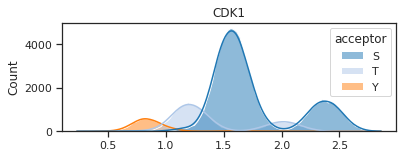

In [ ]:
plot_hist(df,'CDK1')

In [ ]:
y = get_genes('CDK1',s=2.0,t=1.65)

(116887, 3)
(123515, 3)
exporting csv file for st


In [ ]:
y = get_genes('CDK1',s=2.0,t=1.65)

(116887, 3)
(123515, 3)
exporting csv file for st


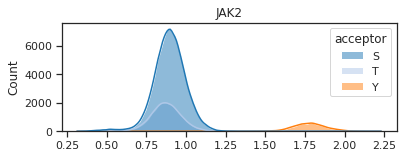

In [ ]:
plot_hist(df,'JAK2')# Y: 2.0

In [ ]:
_ = get_genes('JAK2',y=2.0)

(116887, 3)
(123515, 3)
exporting csv file for st


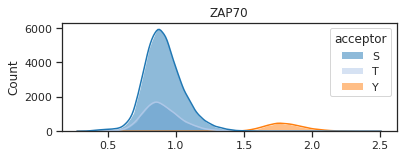

In [ ]:
plot_hist(df,'ZAP70') # Y: 2.1

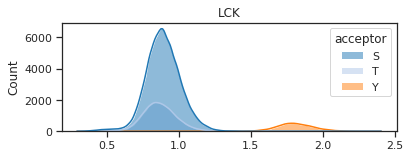

In [ ]:
plot_hist(df,'LCK') # Y: 2.1

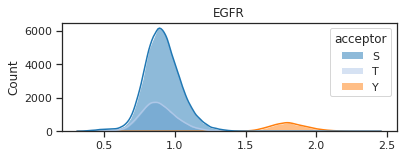

In [ ]:
plot_hist(df,'EGFR') # Y: 2.1

In [ ]:
y = get_genes('EGFR',y=2.0)

(116887, 3)
(123515, 3)
exporting csv file for st


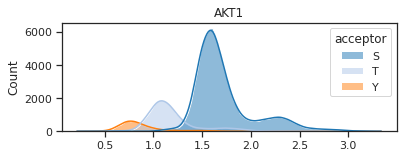

In [ ]:
plot_hist(df,'AKT1') # S: 2.55, T: 1.6

In [ ]:
y = get_genes('AKT1',s=2.55,t=1.6)

(116887, 3)
(123515, 3)
exporting csv file for st


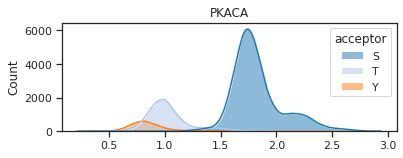

In [ ]:
plot_hist(df,'PKACA') # S: 2.5, T: 1.5

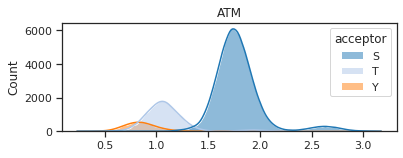

In [ ]:
plot_hist(df,'ATM') # S: 2.3, T: 1.55

In [ ]:
st = get_genes('ATM',s=2.3,t=1.55)

(116887, 3)
(123515, 3)
exporting csv file for st
